In [1]:
import sys

import matplotlib.pyplot as plt
import json

import numpy as np

# import dysts
# from dysts.flows import *
# from dysts.base import *
# from dysts.utils import *
# from dysts.analysis import *

# try:
#     from private.lyap import lyap_r, lyap_e, corr_dim
# except:
#     from nolds import lyap_r, lyap_e, corr_dim


%load_ext autoreload
%autoreload 2

## Symbolic regression

Available benchmarks

+ Eureqa Python API (could not get this to work)
+ PySR
+ pySINDY
+ AI Feynman 2.0

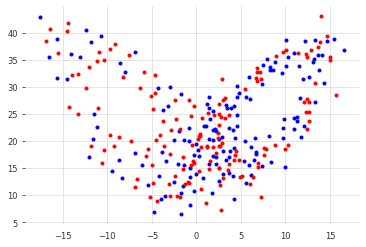

In [18]:


from dysts.flows import Lorenz
from dysts.analysis import sample_initial_conditions

n_train = 150
model = Lorenz()

ic_train, ic_test = sample_initial_conditions(model, 2, traj_length=1000, pts_per_period=30)

model.ic = ic_train
tvals, sol = model.make_trajectory(n_train, pts_per_period=15, resample=True, return_times=True, standardize=False)
dt = np.median(np.diff(tvals))
dsol = np.vstack(model.rhs(sol, 0)).T * dt
y_train = dsol[:, 0]
X_train = sol

model.ic = ic_test
tvals, sol = model.make_trajectory(n_train, pts_per_period=15, resample=True, return_times=True, standardize=False)
dt = np.median(np.diff(tvals))
dsol = np.vstack(model.rhs(sol, 0)).T * dt
y_test = dsol[:, 0]
X_test = sol

ndim = X_train.shape[-1]

plt.plot(X_train[:, 0], X_train[:, 2], '.b')
plt.plot(X_test[:, 0], X_test[:, 2], '.r')

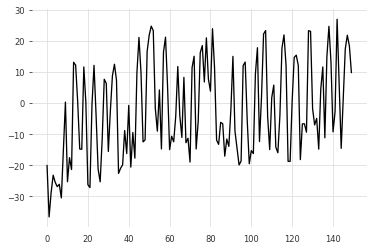

In [18]:
plt.plot(dsol)

In [48]:
import json
import pandas as pd

import darts
from darts import TimeSeries
from darts.metrics import smape

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
# from dysts.analysis import *
from dysts.analysis import sample_initial_conditions


# cwd = os.path.dirname(os.path.realpath(__file__))
cwd = "."
# dataname = os.path.splitext(os.path.basename(os.path.split(input_path)[-1]))[0]
output_path = cwd + "/results/symbolic_scores.json"

n_train = 150

# actual, predicted order
metric_calc = lambda x0, x1 :  smape(TimeSeries.from_dataframe(pd.DataFrame(x0)), TimeSeries.from_dataframe(pd.DataFrame(x1))) / 200.



try:
    with open(output_path, "r") as file:
        sym_scores = json.load(file)
except FileNotFoundError:
    sym_scores = dict()

for i, equation_name in enumerate(get_attractor_list()):
# for i, equation_name in enumerate(["Lorenz"]):
    print(equation_name)
    
    if equation_name in sym_scores.keys():
        print(f"Entry for {equation_name} found, skipping it.")
        continue
    
    model = getattr(dysts.flows, equation_name)()
    sym_scores[equation_name] = dict()
    
    np.random.seed(0)
    ic_train, ic_test = sample_initial_conditions(model, 2, traj_length=1000, pts_per_period=30)

    model.ic = ic_train
    tvals, sol = model.make_trajectory(n_train, pts_per_period=15, resample=True, return_times=True, standardize=False)
    dt = np.median(np.diff(tvals))
    dsol = np.vstack([model.rhs(val, 0) for val in sol])# * dt
    X_train, y_train = sol, dsol

    model.ic = ic_test
    tvals, sol = model.make_trajectory(n_train, pts_per_period=15, resample=True, return_times=True, standardize=False)
    dt = np.median(np.diff(tvals))
    dsol = np.vstack([model.rhs(val, 0) for val in sol])# * dt
    X_test, y_test = sol, dsol
    
    ndim = min([X_test.shape[-1], y_test.shape[-1]])
    
    
    ## SINDY-poly
    import pysindy as ps
    sym_model = ps.SINDy()
    sym_model.fit(X_train, t=tvals)
    y_test_pred = sym_model.predict(X_test)
    all_scores = list()
    for i in range(ndim):
        all_scores.append(metric_calc(y_test[:, i], y_test_pred[:, i]))
    sym_scores[equation_name]["SINDY-poly"] = np.median(all_scores)
    
    ## SINDY-fourier basis
    sym_model = ps.SINDy(feature_library=ps.FourierLibrary(n_frequencies=10))
    sym_model.fit(X_train, t=tvals)
    y_test_pred = sym_model.predict(X_test)
    all_scores = list()
    for i in range(ndim):
        all_scores.append(metric_calc(y_test[:, i], y_test_pred[:, i]))
    sym_scores[equation_name]["SINDY-fourier"] = np.median(all_scores)
    
    
#     break
    
    with open(output_path, 'w') as f:
        json.dump(sym_scores, f, indent=4)   
    

Aizawa
Entry for Aizawa found, skipping it.
AnishchenkoAstakhov
Entry for AnishchenkoAstakhov found, skipping it.
Arneodo
Entry for Arneodo found, skipping it.
ArnoldBeltramiChildress
Entry for ArnoldBeltramiChildress found, skipping it.
ArnoldWeb
Entry for ArnoldWeb found, skipping it.
BeerRNN
Entry for BeerRNN found, skipping it.
BelousovZhabotinsky
Entry for BelousovZhabotinsky found, skipping it.
BickleyJet
Entry for BickleyJet found, skipping it.
Blasius
Entry for Blasius found, skipping it.
BlinkingRotlet
Entry for BlinkingRotlet found, skipping it.
BlinkingVortex
Entry for BlinkingVortex found, skipping it.
Bouali
Entry for Bouali found, skipping it.
Bouali2
Entry for Bouali2 found, skipping it.
BurkeShaw
Entry for BurkeShaw found, skipping it.
CaTwoPlus
Entry for CaTwoPlus found, skipping it.
CaTwoPlusQuasiperiodic
Entry for CaTwoPlusQuasiperiodic found, skipping it.
CellCycle
Entry for CellCycle found, skipping it.
CellularNeuralNetwork
Entry for CellularNeuralNetwork found, s

/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:173: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:173: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


SprottJ
SprottJerk
SprottK
SprottL
SprottM
SprottMore
SprottN
SprottO
SprottP
SprottQ
SprottR
SprottS
SprottTorus


/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/dysts/base.py:152: UserWarning: Expect slowdown due to excessive integration required; scale factor 1449.3263034563563
  if upscale_factor > 1e3: warnings.warn(f"Expect slowdown due to excessive integration required; scale factor {upscale_factor}")


StickSlipOscillator


/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/dysts/base.py:152: UserWarning: Expect slowdown due to excessive integration required; scale factor 1075.2666666666667
  if upscale_factor > 1e3: warnings.warn(f"Expect slowdown due to excessive integration required; scale factor {upscale_factor}")
/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/dysts/base.py:166: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


SwingingAtwood


/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/dysts/base.py:166: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


Thomas


/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/dysts/base.py:152: UserWarning: Expect slowdown due to excessive integration required; scale factor 1149.4332639370807
  if upscale_factor > 1e3: warnings.warn(f"Expect slowdown due to excessive integration required; scale factor {upscale_factor}")
/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:173: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:173: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


ThomasLabyrinth


/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/dysts/base.py:152: UserWarning: Expect slowdown due to excessive integration required; scale factor 1149.4252873563216
  if upscale_factor > 1e3: warnings.warn(f"Expect slowdown due to excessive integration required; scale factor {upscale_factor}")
/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:173: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:173: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


Torus


/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/dysts/base.py:152: UserWarning: Expect slowdown due to excessive integration required; scale factor 1111.111111111111
  if upscale_factor > 1e3: warnings.warn(f"Expect slowdown due to excessive integration required; scale factor {upscale_factor}")


Tsucs2
TurchinHanski


/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/dysts/base.py:166: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


VallisElNino
VossDelay
WangSun


/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/dysts/base.py:152: UserWarning: Expect slowdown due to excessive integration required; scale factor 1388.8717156105101
  if upscale_factor > 1e3: warnings.warn(f"Expect slowdown due to excessive integration required; scale factor {upscale_factor}")
/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:173: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:173: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


WindmiReduced


/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:173: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


YuWang
YuWang2
ZhouChen


/Users/williamgilpin/miniconda3/envs/symb/lib/python3.8/site-packages/dysts/base.py:152: UserWarning: Expect slowdown due to excessive integration required; scale factor 1190.478133714208
  if upscale_factor > 1e3: warnings.warn(f"Expect slowdown due to excessive integration required; scale factor {upscale_factor}")


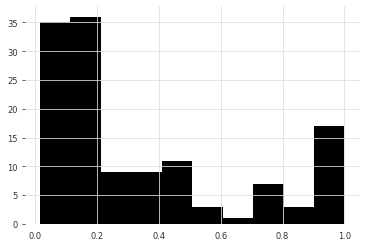

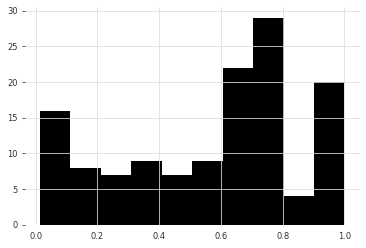

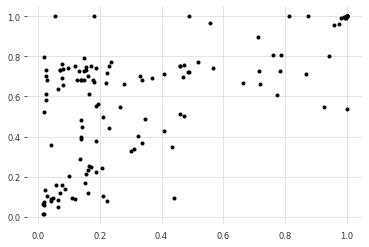

In [60]:
score_vals = np.array([(sym_scores[item]["SINDY-poly"], sym_scores[item]["SINDY-fourier"]) for item in sym_scores])

plt.figure()
plt.hist(score_vals[:, 0])

plt.figure()
plt.hist(score_vals[:, 1])

plt.figure()
plt.plot(*score_vals.T, '.');

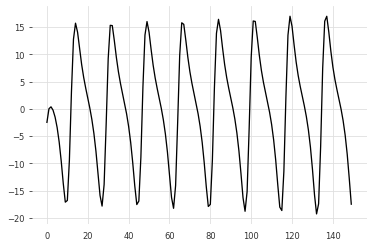

In [75]:
plt.plot(y_train[:, 1])

In [65]:
# import darts
# from darts import TimeSeries
# from darts.metrics import smape

# import pandas as pd

from pysr import pysr, best
y_test_pred = list()
for i in range(ndim):
    print(i)
    # Learn equations
    equations = pysr(
        X_train,
        y_train[:, i],
        populations=3, # number of workers, defaults to 20
        niterations=5,
        procs=1, # number of threads
        binary_operators=["+", "*"],
        unary_operators=[
            "cos",
            "exp",
            "sin",
            "tanh",
            "inv(x) = 1/x",
        ],
        verbosity=0,
    )
    # print(best(equations))
    best_ind = np.argmax(equations["score"].values) 
    y_test_pred.append(equations["lambda_format"].iloc[best_ind](X_test))
y_test_pred = np.array(y_test_pred)

print(metric_calc(y_test, y_test_pred))

0
1
Killing process... will return when done.


RuntimeError: Couldn't find equation file! The equation search likely exited before a single iteration completed.

Init signature: ps.FourierLibrary(n_frequencies=1, include_sin=True, include_cos=True)
Docstring:     
Generate a library with trigonometric functions.

Parameters
----------
n_frequencies : int, optional (default 1)
    Number of frequencies to include in the library. The library will
    include functions :math:`\sin(x), \sin(2x), \dots \sin(n_{frequencies}x)`
    for each input feature :math:`x` (depending on which of sine and/or cosine
    features are included).

include_sin : boolean, optional (default True)
    If True, include sine terms in the library.

include_cos : boolean, optional (default True)
    If True, include cosine terms in the library.

Attributes
----------
n_input_features_ : int
    The total number of input features.

n_output_features_ : int
    The total number of output features. The number of output features
    is ``2 * n_input_features_ * n_frequencies`` if both sines and cosines
    are included. Otherwise it is ``n_input_features * n_frequencies``.

Ex

In [39]:
?ps.SINDy

Init signature:
ps.SINDy(
    optimizer=None,
    feature_library=None,
    differentiation_method=None,
    feature_names=None,
    t_default=1,
    discrete_time=False,
)
Docstring:     
Sparse Identification of Nonlinear Dynamical Systems (SINDy).
Uses sparse regression to learn a dynamical systems model from measurement data.

Parameters
----------
optimizer : optimizer object, optional
    Optimization method used to fit the SINDy model. This must be a class
    extending :class:`pysindy.optimizers.BaseOptimizer`.
    The default is :class:`STLSQ`.

feature_library : feature library object, optional
    Feature library object used to specify candidate right-hand side features.
    This must be a class extending
    :class:`pysindy.feature_library.base.BaseFeatureLibrary`.
    The default option is :class:`PolynomialLibrary`.

differentiation_method : differentiation object, optional
    Method for differentiating the data. This must be a class extending
    :class:`pysindy.differe

In [27]:
y_test[:, i], y_test_pred[:, i]

In [29]:
y_test_pred2.shape

(150, 3)

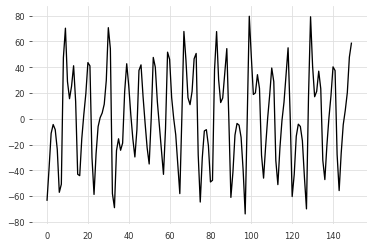

In [26]:
plt.plot(y_test_pred2[:, 0])

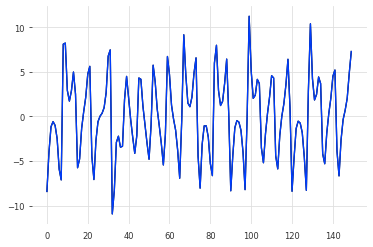

In [16]:
plt.plot(y_test_pred)
plt.plot(y_test)

## nODEs